In [3]:
import os
os.chdir('../')# important if this notebook is not in main but in notebooks folder

from gerda.core.virusPropagationModel import *
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import pandas
import time
import numpy
import math
import scipy.sparse


In [4]:
geopath = 'input_data/geo/'
geofiles = {1:'Buildings_Bad_Feilnbach_MA_1.csv',
            2:'Buildings_Bad_Feilnbach_MA_3.csv',
            3:'Buildings_Gangelt_MA_3.csv',
            4:'Buildings_Gangelt_MA_1.csv'}

In [3]:
modeledWorld1 = ModeledPopulatedWorld(1000,10, world_from_file=True, geofile_name=geopath+geofiles[2], agent_agent_infection=True, input_schedules='schedules_v1')
print('Number of agents: '+ str(modeledWorld1.number_of_people))
print('Distribution of initialized locations: ' + str(modeledWorld1.get_distribution_of_location_types()))

Number of agents: 1452
Distribution of initialized locations: {'hospital': 1, 'morgue': 1, 'work': 24, 'public': 18, 'school': 3, 'home': 713}


In [4]:
people=list(modeledWorld1.people)
Agents_Ages={str(p.ID):p.age for p in people}
Agents_Homes={str(p.ID):p.home.ID for p in people}
Agent_Info=pandas.DataFrame()
Agent_Info['ID']=[int(i) for i in list(Agents_Ages.keys())]
Agent_Info['Age']=list(Agents_Ages.values())
Agent_Info['Home']=list(Agents_Homes.values())




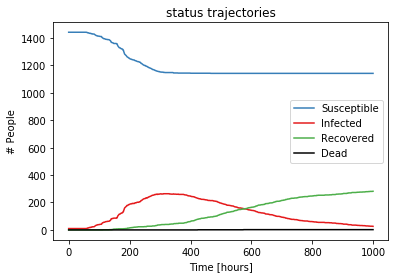

In [19]:
simulation1 = Simulation(modeledWorld1,100,run_immediately=False)
simulation2 = Simulation(modeledWorld1,200,run_immediately=False)


simulation1.interaction_matrix = True
simulation2.interaction_matrix = True
simulation1.interaction_frequency = 2
simulation2.interaction_frequency = 2

simulation1.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.3,'type':'replacement'}}})
simulation2.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.3,'type':'replacement'}}})
#simulation1.simulate()
#simulation1.plot_status_timecourse()


simulation2.simulate()
simulation3 = Simulation(simulation2,500,run_immediately=False)
for p in list(simulation3.people):
    p.stay_home_instead_of_going_to('work')
    p.stay_home_instead_of_going_to('school')
    p.stay_home_instead_of_going_to('public')
simulation3.simulate()

for p in list(simulation3.people):
    p.reset_schedule()
simulation4 = Simulation(simulation3,300,run_immediately=False)
simulation4.simulate()

simulation4.plot_status_timecourse()

In [13]:
def contact_tracing(simulation,tracing_timeframe=336,time_span=[0,None]):
    if time_span[1] is None:
        max_ts=simulation.simulation_timecourse['time'].max()
    else:
        max_ts=time_span[1]

    time_course=simulation.simulation_timecourse[(simulation.simulation_timecourse['time']<=max_ts)&(simulation.simulation_timecourse['time']>=time_span[0])]
    diag_df=time_course.loc[time_course['Temporary_Flags']>=2]
    diagnosed_individuals=list(diag_df['h_ID'].unique())
    
    t_diagnosis={i:diag_df.loc[diag_df['h_ID']==i,'time'].min() for i in diagnosed_individuals}
    t_tracing_period_start={i:t_diagnosis[i]-tracing_timeframe for i in diagnosed_individuals}
    n_contacts={i:len(list(set([k for j in time_course.loc[(time_course['h_ID']==i)&(time_course['time']>=t_tracing_period_start[i])&(time_course['time']<=t_diagnosis[i]),'Interaction_partner'].values[0].split(',') for k in j if k != '']))) for i in diagnosed_individuals}
    n_infections={i:time_course[(time_course['Infection_event']==i)&(time_course['time']>=t_tracing_period_start[i])&(time_course['time']<=t_diagnosis[i])].shape[0] for i in diagnosed_individuals}

    out=pandas.DataFrame()
    out['time']=list(t_diagnosis.values())
    out['traced_infections']=list(n_infections.values())
    out['traced_contacts']=list(n_contacts.values())
    
    out2=out.groupby(['time']).sum()
    out2['day']=[int(i/24) for i in out2.index]

    return(out2)
    
    
    
    



In [ ]:
simulation1 = Simulation(modeledWorld1,1000,run_immediately=False)
simulation1.interaction_matrix = True
simulation1.interaction_frequency = 2

simulation1.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.3,'type':'replacement'}}})
simulation1.simulate()
simulation1.plot_status_timecourse()




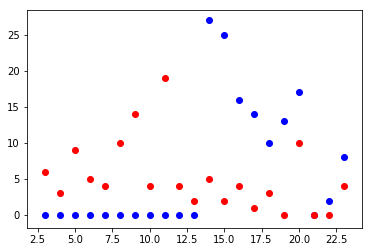

In [20]:
X=contact_tracing(simulation4)    
X2=X.groupby(['day']).sum()
plt.scatter(list(X2.index),list(X2['traced_contacts']),color='blue')
#plt.show()
plt.scatter(list(X2.index),list(X2['traced_infections']),color='red')
plt.show()



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


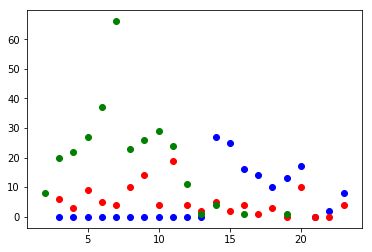

In [21]:
infection_course=simulation4.simulation_timecourse[simulation4.simulation_timecourse['Infection_event']>=0]
infection_course['day']=[int(i/24) for i in infection_course['time']]
Ievents=infection_course.groupby(['day']).count()

plt.scatter(list(X2.index),list(X2['traced_contacts']),color='blue')
#plt.show()
plt.scatter(list(X2.index),list(X2['traced_infections']),color='red')
plt.scatter(list(Ievents.index),list(Ievents['Infection_event']),color='green')

plt.show()



In [22]:
def count_number_of_infected_households(simulation,Agent_Info,time_span=[0,None],total=False):
    if time_span[1] is None:
        max_ts=simulation.simulation_timecourse['time'].max()
    else:
        max_ts=time_span[1]
    time_course=simulation.simulation_timecourse[(simulation.simulation_timecourse['time']<=max_ts)&(simulation.simulation_timecourse['time']>=time_span[0])]
    infected_tc=time_course[time_course['Temporary_Flags']!=0]
    infected_tc['Household']=[Agent_Info.loc[Agent_Info['ID']==i,'Home'].values[0] for i in list(infected_tc['h_ID'])]
    if total:
        return(len(list(infected_tc['Household'].unique()))) 
    else:
        timesteps=list(range(time_span[0],max_ts+1))
        return({t:len(list(infected_tc.loc[infected_tc['time']==t,'Household'].unique())) for t in timesteps})
        

In [31]:
HH=count_number_of_infected_households(simulation4,Agent_Info,time_span=[0,400])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


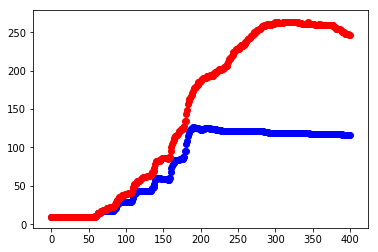

In [32]:
Itraj=simulation4.get_status_trajectories()['I']
plt.scatter(list(HH.keys()),list(HH.values()),color='blue')
plt.scatter(list(Itraj.loc[Itraj['time']<=400,'time']),list(Itraj.loc[Itraj['time']<=400,'I']),color='red')




0.1


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


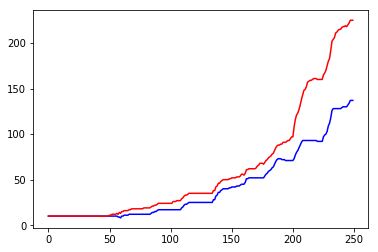

0.5


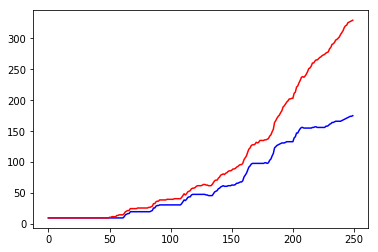

1


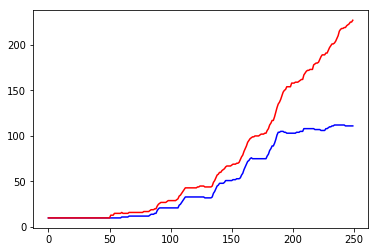

2


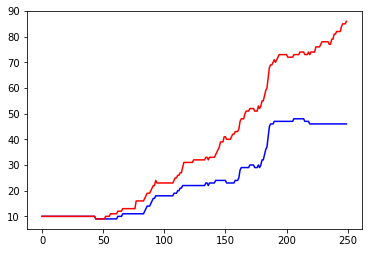

5


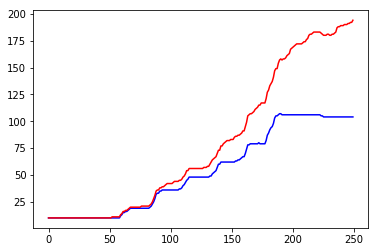

10


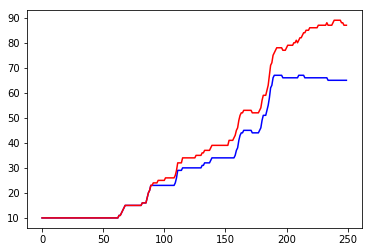

10


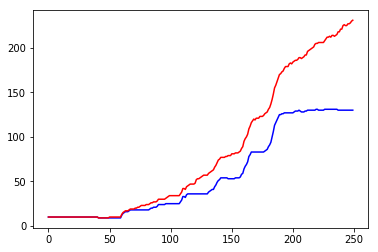

In [40]:
for mu in [0.1,0.5,1,2,5,10]:
    print(mu)
    simulation2 = Simulation(modeledWorld1,200,run_immediately=False)
    simulation2.interaction_matrix = True
    simulation2.interaction_frequency = mu

    simulation2.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.6/mu,'type':'replacement'}}})
    #simulation1.simulate()
    #simulation1.plot_status_timecourse()


    simulation2.simulate()
    simulation3 = Simulation(simulation2,50,run_immediately=False)
    for p in list(simulation3.people):
        p.stay_home_instead_of_going_to('work')
        p.stay_home_instead_of_going_to('school')
        p.stay_home_instead_of_going_to('public')
    simulation3.simulate()
    
    HH=count_number_of_infected_households(simulation3,Agent_Info)
    Itraj=simulation3.get_status_trajectories()['I']
    plt.figure()
    plt.plot(list(HH.keys()),list(HH.values()),color='blue')
    plt.plot(list(Itraj['time']),list(Itraj['I']),color='red')
    plt.show()







10


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


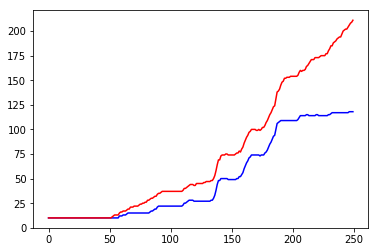

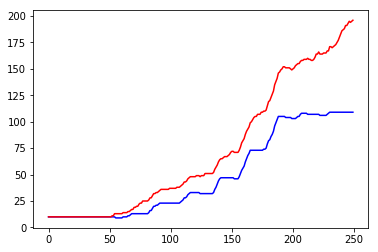

In [41]:
print(mu)
simulation2 = Simulation(modeledWorld1,200,run_immediately=False)
simulation2.interaction_matrix = False
simulation2.interaction_frequency = mu

simulation2.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.3,'type':'replacement'}}})
    #simulation1.simulate()
    #simulation1.plot_status_timecourse()


simulation2.simulate()
simulation3 = Simulation(simulation2,50,run_immediately=False)
for p in list(simulation3.people):
    p.stay_home_instead_of_going_to('work')
    p.stay_home_instead_of_going_to('school')
    p.stay_home_instead_of_going_to('public')
simulation3.simulate()
    
HH=count_number_of_infected_households(simulation3,Agent_Info)
Itraj=simulation3.get_status_trajectories()['I']
plt.figure()
plt.plot(list(HH.keys()),list(HH.values()),color='blue')
plt.plot(list(Itraj['time']),list(Itraj['I']),color='red')
plt.show()






simulation2 = Simulation(modeledWorld1,200,run_immediately=False)
simulation2.interaction_matrix = True
simulation2.interaction_frequency = 2

simulation2.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.3,'type':'replacement'}}})
    #simulation1.simulate()
    #simulation1.plot_status_timecourse()

simulation2.simulate()
simulation3 = Simulation(simulation2,50,run_immediately=False)
for p in list(simulation3.people):
    p.stay_home_instead_of_going_to('work')
    p.stay_home_instead_of_going_to('school')
    p.stay_home_instead_of_going_to('public')
simulation3.simulate()
    
HH=count_number_of_infected_households(simulation3,Agent_Info)
Itraj=simulation3.get_status_trajectories()['I']
plt.figure()
plt.plot(list(HH.keys()),list(HH.values()),color='blue')
plt.plot(list(Itraj['time']),list(Itraj['I']),color='red')
plt.show()

